# The Most Educated Places in the U.S.

Earlier this week I came across an article on the [most educated places in the US](
http://www.businessinsider.com/most-educated-places-map-2014-9). I thought it would be cool to try to recreate their findings and expand upon by taking into account the uncertainty of the survey results.

Let's get started.

### Setup

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import us

### Read data

We need two variables for each place in the US:
* Percent of population over 25 with a bachelor's degree or higher (called educational attainment from now on)
* Total population

We'll also grab the margin of error for these variables. We'll use them later.

In [3]:
def state_and_place(df):
    """Extracts state and place from the original identification variable."""
    columns = (
        df
        .id
        .astype(str)
        .str.extract('(?P<state_fips>\d{1,2})(?P<place_fips>\d{5})', expand=True)
        .astype(int)
    )
    return df.join(columns)

In [4]:
def read_acs(year):
    """Reads and formats ACS educational attainment data for a given year."""
    filename = '../data/ACS_{year}_5YR_S1501/ACS_{year}_5YR_S1501_with_ann.csv'.format(year=str(year)[-2:])
    
    na_values = ('**', '-', '+', '***', '*****', 'N', '(X)')

    variables = {
        'Id2': 'id',
        'Geography': 'place',
        "Total; Estimate; Percent bachelor's degree or higher": 'pct_bachelor_plus',
        "Total; Margin of Error; Percent bachelor's degree or higher": 'pct_bachelor_plus_moe'
    }
    
    return (
        pd
        .read_csv(
            filename,
            usecols=variables.keys(),
            na_values=na_values,
            # https://www.census.gov/geo/maps-data/data/tiger/char_encoding.html
            encoding='ISO-8859-1',
            skiprows=1
        )
        .rename(columns=variables)
        .pipe(state_and_place)
        .drop('id', axis=1)
        .set_index(['state_fips', 'place_fips'])
    )

In [5]:
def read_population(year):
    """Collects and formats population data from the Census API for a given year."""
    url = 'http://api.census.gov/data/{}/acs5?get=B01003_001E,B01003_001M&for=place:*'.format(year)
    r = requests.get(url)
    data = r.json()
    
    columns = {
        'B01003_001E': 'population',
        'B01003_001M': 'population_moe',
        'state': 'state_fips',
        'place': 'place_fips'
    }
    
    return (
        pd.DataFrame(data=data[1:], columns=data[0])
        .rename(columns=columns)
        .apply(lambda s: s.astype(int))
        .set_index(['state_fips', 'place_fips'])
    )

In [6]:
def state(df):
    """Converts state FIPS codes to state names."""
    data = (
        df
        .index
        .get_level_values('state_fips')
        .astype(str)
        .str.rjust(2, fillchar='0')
    )
    s = pd.Series(data=data, index=df.index)
    
    return s.apply(lambda x: us.states.lookup(x).name)

In [7]:
def read_data(year):
    """Reads and formats desired ACS data for a given year."""
    acs = read_acs(year)
    population = read_population(year)
    
    return (
        acs
        .join(population)
        .assign(state=state)
        .set_index(['state', 'place'])
        .sort_index(axis=1)
    )

In [8]:
df = read_data(2012)

### Let's check out the dataset

Whenever I work with a dataset for the first time I like to do a few things:
* Check out the shape/composition.
* Look at the top few rows.
* Look at the bottom two rows.
* Get a sense of how things are distributed.

In [9]:
# Composition
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 29256 entries, (Alabama, Abanda CDP, Alabama) to (Wyoming, Y-O Ranch CDP, Wyoming)
Data columns (total 4 columns):
pct_bachelor_plus        29029 non-null float64
pct_bachelor_plus_moe    29029 non-null float64
population               29256 non-null int32
population_moe           29256 non-null int32
dtypes: float64(2), int32(2)
memory usage: 914.2+ KB


In [10]:
# Top
df.head()

pct_bachelor_plus  pct_bachelor_plus_moe  \
state   place                                                                
Alabama Abanda CDP, Alabama                     0.0                   45.8   
        Abbeville city, Alabama                16.9                    5.7   
        Adamsville city, Alabama               12.3                    3.9   
        Addison town, Alabama                  17.8                   10.5   
        Akron town, Alabama                     7.9                    8.7   

                                  population  population_moe  
state   place                                                 
Alabama Abanda CDP, Alabama               42              31  
        Abbeville city, Alabama         2699              18  
        Adamsville city, Alabama        4537              26  
        Addison town, Alabama            826             284  
        Akron town, Alabama              369             141

In [11]:
# Bottom
df.tail()

pct_bachelor_plus  \
state   place                                                
Wyoming Woods Landing-Jelm CDP, Wyoming               40.6   
        Worland city, Wyoming                         20.4   
        Wright town, Wyoming                          14.3   
        Yoder town, Wyoming                           15.9   
        Y-O Ranch CDP, Wyoming                         0.0   

                                         pct_bachelor_plus_moe  population  \
state   place                                                                
Wyoming Woods Landing-Jelm CDP, Wyoming                   17.7          91   
        Worland city, Wyoming                              3.9        5426   
        Wright town, Wyoming                               4.3        2216   
        Yoder town, Wyoming                               15.0         149   
        Y-O Ranch CDP, Wyoming                            16.1         223   

                                         population_moe  
state   place                                            
Wyoming Woods Landing-Jelm CDP, Wyoming             102  
        Worland city, Wyoming                        18  
        Wright town, Wyoming                        382  
        Yoder town, Wyoming                         104  
        Y-O Ranch CDP, Wyoming                      109

In [12]:
# Summary
df.dropna().describe()

,pct_bachelor_plus,pct_bachelor_plus_moe,population,population_moe
count,29029.000000,29029.000000,2.902900e+04,29029.000000
mean,20.028689,9.109429,7.903848e+03,190.236625
std,16.372341,11.247205,6.613706e+04,221.437532
min,0.000000,0.200000,1.000000e+00,0.000000
25%,9.100000,4.000000,3.460000e+02,48.000000
50%,15.700000,5.800000,1.106000e+03,123.000000
75%,26.000000,9.200000,4.100000e+03,245.000000
max,100.000000,100.000000,8.199221e+06,3536.000000


### Population vs. Attainment

We can see right away that we're dealing with some pretty heavily skewed data. Most places are teeny-tiny, while some are massive (I see you New York). Most also tend to have educational attainment rates (i.e., percent of the population over 25 with bachelor's degrees) around 10-20%, though some go all the way to 100%! More on that later.

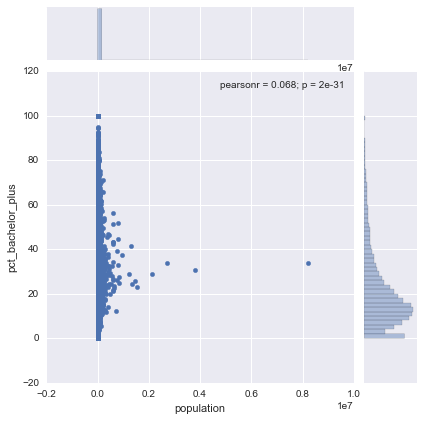

In [13]:
sns.jointplot('population', 'pct_bachelor_plus', data=df);

### Recreating the original metric

To make sure I'm starting off right, I wanted to try to recreate the original ranking. Fortunately the author was explicit with his methodology, so recreating was a breeze.

In [14]:
colleges = (
    'Stanford CDP, California',
    'University at Buffalo CDP, New York',
    'University of Pittsburgh Johnstown CDP, Pennsylvania',
    'Mississippi State CDP, Mississippi',
    'St. Vincent College CDP, Pennsylvania',
    'University CDP, Mississippi'
)

In [15]:
def highest_attainment_orig(df, filter_=True):
    """Gets the place with the higehst educational attainment in each state."""
    if filter_:
        # Only include places with at least 1,000 people, excluding colleges
        subset = df.loc[(df.population > 1000) & (df.index.map(lambda x: x[1] not in colleges))]
    else:
        subset = df
    # Find the place with the higehst attainment by state
    idx = (
        subset
        .groupby(level='state')
        .pct_bachelor_plus
        .transform('max')
        .eq(subset.pct_bachelor_plus)
    )
    
    return subset.loc[idx].reset_index('state', drop=True)

In [16]:
(
    df
    .pipe(highest_attainment_orig)
    .pct_bachelor_plus
    .sort_values(ascending=False)
)

place
Chevy Chase town, Maryland                 92.7
Ladera CDP, California                     89.3
Winnetka village, Illinois                 88.4
Mission Hills city, Kansas                 88.1
Short Hills CDP, New Jersey                87.1
Belle Meade city, Tennessee                86.4
Lost Creek CDP, Texas                      86.3
Scarsdale village, New York                84.9
Castleton CDP, Vermont                     84.2
Shorewood Hills village, Wisconsin         83.6
Yarrow Point town, Washington              83.1
Old Greenwich CDP, Connecticut             83.0
Hanover CDP, New Hampshire                 83.0
Mountain Brook city, Alabama               82.9
Ladue city, Missouri                       82.6
Druid Hills CDP, Georgia                   81.8
The Village of Indian Hill city, Ohio      81.2
McLean CDP, Virginia                       81.2
Edgeworth borough, Pennsylvania            81.2
Wellesley CDP, Massachusetts               80.8
Pine Brook Hill CDP, Colorado     

Here's the original list, for comparison:
![top_places](http://static4.businessinsider.com/image/5410991d6bb3f70a0c123b31-960/most%20educated%20places%20table.png)

### The Problem: Uncertainty

One thing I was curious about was why the author decided to include only places with more than 1,000 people. What does this list look like if we include all places?

In [17]:
(
    df
    .pipe(highest_attainment_orig, filter_=False)
    .sort_values('pct_bachelor_plus', ascending=False)
)

,pct_bachelor_plus,pct_bachelor_plus_moe,population,population_moe
place,,,,
"Lakeview North CDP, Wyoming",100.0,85.6,12,19
"Gloster CDP, Louisiana",100.0,68.8,20,31
"Allen CDP, Maryland",100.0,24.6,168,170
"Zion CDP, Oklahoma",100.0,100.0,2,4
"Ocean CDP, Maryland",100.0,100.0,7,10
"Seconsett Island CDP, Massachusetts",100.0,65.6,22,26
"Prairie City CDP, South Dakota",100.0,100.0,2,3
"Bridger CDP, Montana",100.0,52.0,53,75
"Turtle Lake CDP, Montana",100.0,51.0,70,111


That's a lot of 100%s. One thing to notice is that the confidence interval for these places are massive. Zion CDP, Oklahoma, for example, has a 90% CI of [0, 100]. The interval includes every value this variable can take! While filtering these small, highly-uncertain places is a good heuristic, there are more robust ways to handle this isuse.

One way is to use the 90% least plausible value, defined as the value such that there is only a 10% chance the true parameter is lower. In other words, the smartest places, according to this procedure, are the places that are _most likely_ to have a high percentage of people with educational attainment. This works well because even if we completely overestimate the educational attainment rates we can be sure the top places are still on top.

The great thing about the [American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs/about.html) is that they provide margins of error (MoE) for all of their estimate variables. Best of all, their MoE are for 90% confidence intervals. All we need to do is subtract the MoE from the estimate!

# A more conservative approach

In [18]:
def lower_bound(df, column):
    """Gets the 90% confidence interval lower bound for a variable."""
    lower = df[column] - df['{}_moe'.format(column)]
    # Minimum value is 0
    lower.loc[lower < 0] = 0
    
    return lower

In [19]:
def add_lower_bounds(df):
    """Adds the lower bounds for population and educational attainment."""
    return (
        df
        .assign(
            population_lower=lambda df: df.pipe(lower_bound, 'population'),
            pct_bachelor_plus_lower=lambda df: df.pipe(lower_bound, 'pct_bachelor_plus')
        )
    )

In [20]:
df = df.pipe(add_lower_bounds)

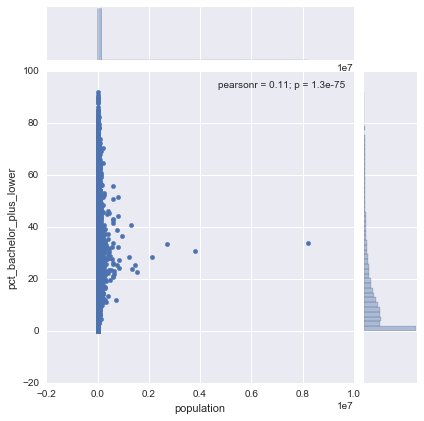

In [21]:
sns.jointplot('population', 'pct_bachelor_plus_lower', data=df);

You'll notice that the educational attainment distribution is even more skewed than before! This is because so many places are small and therefore have a lot of uncertainty associated with their estimates. These places will be unlikely to show up on our list (as they shouldn't).

In [22]:
def highest_attainment(df):
    """Find the place with the higehst attainment by state, using the lower bound."""
    subset = df.loc[df.index.map(lambda x: x[1] not in colleges)]
    idx = (
        subset
        .groupby(level='state')
        .pct_bachelor_plus_lower
        .transform('max')
        .eq(subset.pct_bachelor_plus_lower)
    )
    
    return (
        subset
        .loc[idx]
        .reset_index('state', drop=True)
    )

In [23]:
def plot_highest(df):
    """Creates an errorbar plot for attainment data."""
    highest = df.sort_values('pct_bachelor_plus_lower')

    plt.figure(figsize=(16, 10))
    plt.errorbar(
        highest.pct_bachelor_plus,
        np.arange(len(highest)),
        xerr=highest.pct_bachelor_plus_moe,
        fmt='o'
    )

    plt.xlim(40, 100)
    plt.ylim(-1, len(highest))
    plt.yticks(np.arange(len(highest)), highest.index)

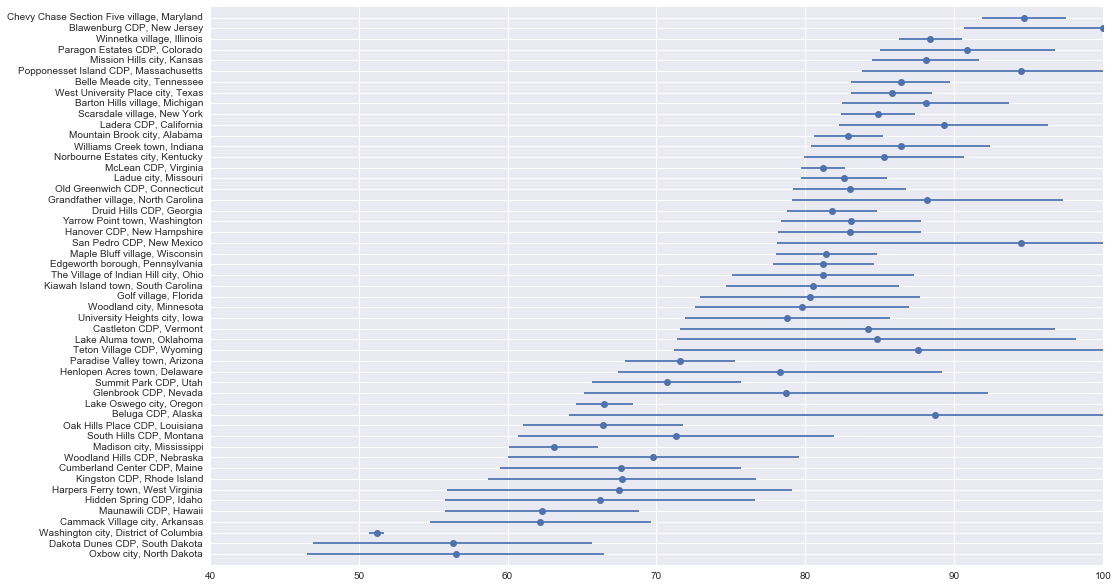

In [24]:
df.pipe(highest_attainment).pipe(plot_highest)

In the plot above we have the point estimate (the dot) and its confidence interval, ordered by the 90% least plausible value (i.e., the lower end of the CI). Compared to the original results, about half of the top places have changed.

### How do things look now?

The original data is a few years old. Let's see how things look with 2010-2014 data.

In [25]:
df_14 = read_data(2014)

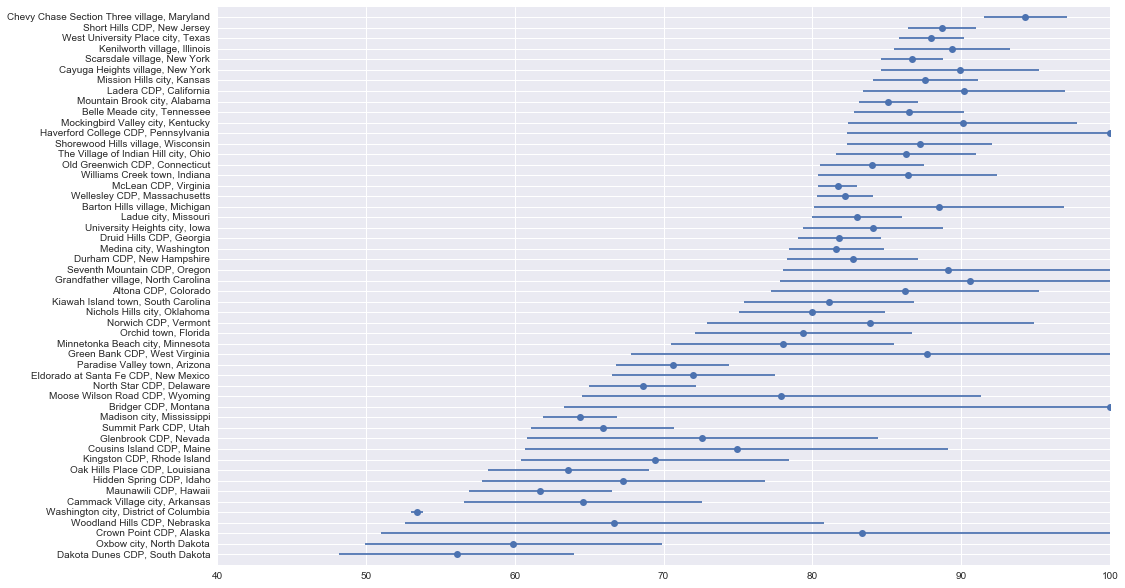

In [26]:
df_14.pipe(add_lower_bounds).pipe(highest_attainment).pipe(plot_highest)

### Improvements

I don't think places are a good unit of analysis for this kind of work. Many are subsets of larger cities, which can be misleading.

An alternative would be to use metropolitian/micropolitan statistical areas and see how things change. The issue there is than smaller geographies are underrepresented (or not represented at all).

I'd like to try a hybrid approach: Use MSA where possible, otherwise use place. That allows us to acknowledge agglomeration effects, where applicable. I would need to find a mapping of places to MSAs. If that doesn't exist (quick Google search suggest it doesn't), I'd have to create one using Census TIGER shapefiles, which is easy to do with something like PostGIS or QGIS.

### Acknowledgements

Huge thanks goes to [Andy Kiersz](https://twitter.com/AndyKiersz), the author of the original article, for the inspiration.

Much of the discussion on uncertainty comes from [Cameron Davidson-Pilon's](https://twitter.com/Cmrn_DP) book [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers). Can't recommend it enough.